In [478]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import re

In [479]:
df = pd.read_csv("./Novel_Corona_Virus_Dataset/covid_19_data.csv", header=0, index_col=0)

In [480]:
df.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [481]:
df.columns = ["Date_Observed", "State", "Country", "Last_Update", "Confirmed", "Deaths", "Recovered"]

In [482]:
df = df[df["Country"] == "US"]
df

,Date_Observed,State,Country,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
32,01/22/2020,Washington,US,1/22/2020 17:00,1.0,0.0,0.0
70,01/23/2020,Washington,US,1/23/20 17:00,1.0,0.0,0.0
118,01/24/2020,Washington,US,1/24/20 17:00,1.0,0.0,0.0
119,01/24/2020,Chicago,US,1/24/20 17:00,1.0,0.0,0.0
159,01/25/2020,Washington,US,1/25/20 17:00,1.0,0.0,0.0
...,...,...,...,...,...,...,...
205918,01/19/2021,Virginia,US,2021-01-20 05:21:54,451076.0,5798.0,0.0
205928,01/19/2021,Washington,US,2021-01-20 05:21:54,289939.0,3903.0,0.0
205931,01/19/2021,West Virginia,US,2021-01-20 05:21:54,110820.0,1815.0,0.0


### Gather all the states from hosp dataset in the novel corona virus dataset

In [483]:
hosp_states = ["Tennessee","Utah","California","Colorado","Entire" "Network","Connecticut","Georgia","Iowa","Maryland","Michigan","Minnesota","New Mexico","New York","Ohio","Oregon"]
partial_states = ["CA","CO","CT","GA","MD","MN", "NM","NY","OR","TN","IA","MI","OH","UT"]
state_dict = dict(zip(partial_states, hosp_states))

## Remove abbreviations from the indices
def rename_states(row):
    for p_state in partial_states:
        if re.search(p_state, row["State"]) != None:
            row["State"] = state_dict[p_state]
            break
        
    return row


boolean = '|'.join(hosp_states)

hospDf = df[df["State"].str.contains(boolean)]
hospDf = hospDf.apply(rename_states, axis=1)
hospDf["State"].unique()









array(['California', 'Iowa', 'New York', 'Georgia', 'Colorado', 'Oregon',
       'Maryland', 'Tennessee', 'Minnesota', 'Ohio', 'Connecticut',
       'Utah', 'Michigan', 'New Mexico'], dtype=object)

In [484]:
hospDf

,Date_Observed,State,Country,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
205,01/26/2020,California,US,1/26/20 16:00,2.0,0.0,0.0
252,01/27/2020,California,US,1/27/20 23:59,2.0,0.0,0.0
303,01/28/2020,California,US,1/28/20 23:00,2.0,0.0,0.0
355,01/29/2020,California,US,1/29/20 19:30,2.0,0.0,0.0
410,01/30/2020,California,US,1/30/20 16:00,2.0,0.0,0.0
...,...,...,...,...,...,...,...
205710,01/19/2021,New York,US,2021-01-20 05:21:54,1268692.0,41368.0,0.0
205738,01/19/2021,Ohio,US,2021-01-20 05:21:54,836049.0,10323.0,0.0
205746,01/19/2021,Oregon,US,2021-01-20 05:21:54,133851.0,1803.0,0.0


### We want to find the ratio of people with confirmed cases that are hospitalized. We will use the following equation to achieve this

Ratio = (population of state * (# of hospitalizations)/100000)/Confirmed Cases

### Here are the variables that we need
1. Know how to get the population of state through the census
2. Get # of hospitalizations per 100000
3. Aggregate Confirmed Cases weekly over the epidemological weeks defined in COVID-NET
4. pd.join "# of hospitalizations" table with aggregate table, using the keys=["Date", "State"]
5. Use apply to get the hospitalization ratio

In [485]:
df_census = pd.read_csv("./US_CENSUS/nst-est2020.csv", usecols=["POPESTIMATE2020", "NAME"], header=0)
df_census.head()

,NAME,POPESTIMATE2020
0,United States,329484123
1,Northeast Region,55849869
2,Midwest Region,68316744
3,South Region,126662754
4,West Region,78654756


In [486]:
df_census = df_census[df_census["NAME"].str.contains(boolean)]
df_census = dict(zip(list(df_census["NAME"]), list(df_census["POPESTIMATE2020"])))
df_census



{'California': 39368078,
 'Colorado': 5807719,
 'Connecticut': 3557006,
 'Georgia': 10710017,
 'Iowa': 3163561,
 'Maryland': 6055802,
 'Michigan': 9966555,
 'Minnesota': 5657342,
 'New Mexico': 2106319,
 'New York': 19336776,
 'Ohio': 11693217,
 'Oregon': 4241507,
 'Tennessee': 6886834,
 'Utah': 3249879}

In [487]:
df_hospitalizations = pd.read_csv("./data/valid_df.csv", header=0)
df_hospitalizations["date"] = pd.to_datetime(df_hospitalizations["date"])
interests = df_hospitalizations["age_category"].str.contains("Overall|0-4 yr|5-17 yr|18-49 yr|50-64 yr|65\+ yr") ## We only want these age categories
df_hospitalizations = df_hospitalizations[interests]

## verify our states all match
print(np.sort(df_hospitalizations["catchment"].unique()) == np.sort(np.array(list(df_census.keys()))))
print(np.sort(df_hospitalizations["catchment"].unique()) == np.sort(hospDf["State"].unique()))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [488]:
hospDf.head()

,Date_Observed,State,Country,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
205,01/26/2020,California,US,1/26/20 16:00,2.0,0.0,0.0
252,01/27/2020,California,US,1/27/20 23:59,2.0,0.0,0.0
303,01/28/2020,California,US,1/28/20 23:00,2.0,0.0,0.0
355,01/29/2020,California,US,1/29/20 19:30,2.0,0.0,0.0
410,01/30/2020,California,US,1/30/20 16:00,2.0,0.0,0.0


In [489]:
hospDf.shape

(4438, 7)

In [490]:
hospDf = hospDf.sort_values("State")
hospDf.dtypes

Date_Observed     object
State             object
Country           object
Last_Update       object
Confirmed        float64
Deaths           float64
Recovered        float64
dtype: object

Let's get the confirmed cases in weeks starting from March 1st, 2020. The start of the first epidemological week and ends on March 7th as indicated on the dataset on cdc.gov: https://gis.cdc.gov/grasp/COVIDNet/COVID19_3.html

In [491]:
hospDf["Date_Observed"] = pd.to_datetime(hospDf["Date_Observed"])
dateBool = (hospDf["Date_Observed"] >= "03/01/2020") & (hospDf["Date_Observed"] <= hospDf["Date_Observed"].max()) 
hospDf = hospDf[dateBool].sort_values("Date_Observed")
tempUpdate = hospDf[hospDf["Date_Observed"] == hospDf["Date_Observed"].min()]
tempUpdate["Date_Observed"] = hospDf["Date_Observed"].min() - datetime.timedelta(days=1) ## Shift min from 03/02/2020 ti 03/01/2020
hospDf.update(tempUpdate)
hospDf

,Date_Observed,State,Country,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
3072,2020-03-01,Iowa,US,2020-03-02T01:53:03,1.0,0.0,0.0
3221,2020-03-03,Iowa,US,2020-03-02T01:53:03,1.0,0.0,0.0
3384,2020-03-04,Iowa,US,2020-03-02T01:53:03,1.0,0.0,0.0
3493,2020-03-05,Iowa,US,2020-03-05T21:03:13,4.0,0.0,0.0
3643,2020-03-06,Iowa,US,2020-03-06T19:13:40,16.0,0.0,0.0
...,...,...,...,...,...,...,...
205710,2021-01-19,New York,US,2021-01-20 05:21:54,1268692.0,41368.0,0.0
205676,2021-01-19,Minnesota,US,2021-01-20 05:21:54,448268.0,6013.0,0.0
205708,2021-01-19,New Mexico,US,2021-01-20 05:21:54,164954.0,2975.0,0.0


In [492]:
dfWeekly = hospDf.groupby([pd.Grouper(key="Date_Observed", freq='W'), "State"]).sum()
dfWeekly

Confirmed   Deaths  Recovered
Date_Observed State                                     
2020-03-01    Iowa               1.0      0.0        0.0
2020-03-08    Iowa              45.0      0.0        0.0
2020-03-15    California      1590.0     24.0       28.0
              Colorado         375.0      2.0        0.0
              Connecticut       67.0      0.0        0.0
...                              ...      ...        ...
2021-01-24    New York     2524663.0  82541.0        0.0
              Ohio         1667115.0  20604.0        0.0
              Oregon        267702.0   3606.0        0.0
              Tennessee    1377816.0  16901.0        0.0
              Utah          651140.0   3007.0        0.0

[646 rows x 3 columns]

In [493]:
## Reconstructing the tuples so that time is shifted to the end of the week
dfWeekly.index = pd.MultiIndex.from_tuples([(index[0] + datetime.timedelta(days=6), index[1]) for index in dfWeekly.index], names=["date", "catchment"])
dfWeekly.index

MultiIndex([('2020-03-07',        'Iowa'),
            ('2020-03-14',        'Iowa'),
            ('2020-03-21',  'California'),
            ('2020-03-21',    'Colorado'),
            ('2020-03-21', 'Connecticut'),
            ('2020-03-21',     'Georgia'),
            ('2020-03-21',        'Iowa'),
            ('2020-03-21',    'Maryland'),
            ('2020-03-21',    'Michigan'),
            ('2020-03-21',   'Minnesota'),
            ...
            ('2021-01-30',        'Iowa'),
            ('2021-01-30',    'Maryland'),
            ('2021-01-30',    'Michigan'),
            ('2021-01-30',   'Minnesota'),
            ('2021-01-30',  'New Mexico'),
            ('2021-01-30',    'New York'),
            ('2021-01-30',        'Ohio'),
            ('2021-01-30',      'Oregon'),
            ('2021-01-30',   'Tennessee'),
            ('2021-01-30',        'Utah')],
           names=['date', 'catchment'], length=646)

### Let's Review this

### We want to find the ratio of people with confirmed cases that are hospitalized. We will use the following equation to achieve this

Ratio = (population of state * (# of hospitalizations)/100000)/Confirmed Cases

### Here are the variables that we need
1. Know how to get the population of state through the census
2. Get # of hospitalizations per 100000
3. Aggregate Confirmed Cases weekly over the epidemological weeks defined in COVID-NET
4. pd.join to "# of hospitalizations" table with the other two tables, using the keys=["Date", "State"]
5. Use apply to get the hospitalization ratio

In [494]:
dfWeekly

Confirmed   Deaths  Recovered
date       catchment                                 
2020-03-07 Iowa               1.0      0.0        0.0
2020-03-14 Iowa              45.0      0.0        0.0
2020-03-21 California      1590.0     24.0       28.0
           Colorado         375.0      2.0        0.0
           Connecticut       67.0      0.0        0.0
...                           ...      ...        ...
2021-01-30 New York     2524663.0  82541.0        0.0
           Ohio         1667115.0  20604.0        0.0
           Oregon        267702.0   3606.0        0.0
           Tennessee    1377816.0  16901.0        0.0
           Utah          651140.0   3007.0        0.0

[646 rows x 3 columns]

In [495]:
df_hospitalizations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8736 entries, 0 to 8735
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   catchment        8736 non-null   object        
 1   network          8736 non-null   object        
 2   year             8736 non-null   int64         
 3   mmwr_year        8736 non-null   int64         
 4   mmwr_week        8736 non-null   int64         
 5   age_category     8736 non-null   object        
 6   sex              8736 non-null   object        
 7   race             8736 non-null   object        
 8   cumulative_rate  8736 non-null   float64       
 9   weekly_rate      8736 non-null   float64       
 10  date             8736 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 819.0+ KB


In [496]:
## Drop overalls, then split categories, and add up weekly rates from every age group together,
only_overalls = (df_hospitalizations["age_category"] == "Overall") & \
                (df_hospitalizations["sex"] == "Overall") & \
                (df_hospitalizations["race"] == "Overall")

df_hospitalizations_sum = df_hospitalizations[~only_overalls]

boolean = "age_category|sex|race"
df_hospitalizations_sum = pd.melt(df_hospitalizations, id_vars=df_hospitalizations.loc[:, ~df_hospitalizations.columns.str.contains(boolean)], value_vars=boolean.split("|"), var_name="category", value_name="value")
df_hospitalizations = pd.melt(df_hospitalizations, id_vars=df_hospitalizations.loc[:, ~df_hospitalizations.columns.str.contains(boolean)], value_vars=boolean.split("|"), var_name="category", value_name="value")
df_hospitalizations_sum["date"] = pd.to_datetime(df_hospitalizations_sum["date"])
summed_results = df_hospitalizations_sum[df_hospitalizations_sum["value"] != "Overall"].sort_values(["catchment", "date"]).groupby(["catchment", "date", "category"], as_index=False).sum()

In [497]:
summed_results = summed_results.drop(["mmwr_year", "mmwr_week", "year"], axis=1)

In [498]:
summed_results.head()

,catchment,date,category,cumulative_rate,weekly_rate
0,California,2020-03-07,age_category,0.7,0.7
1,California,2020-03-07,race,0.7,0.7
2,California,2020-03-07,sex,0.4,0.4
3,California,2020-03-14,age_category,4.6,3.9
4,California,2020-03-14,race,3.5,2.8


In [477]:
dfWeekly

Confirmed   Deaths  Recovered
date       catchment                                 
2020-03-07 Iowa               1.0      0.0        0.0
2020-03-14 Iowa              45.0      0.0        0.0
2020-03-21 California      1590.0     24.0       28.0
           Colorado         375.0      2.0        0.0
           Connecticut       67.0      0.0        0.0
...                           ...      ...        ...
2021-01-30 New York     2524663.0  82541.0        0.0
           Ohio         1667115.0  20604.0        0.0
           Oregon        267702.0   3606.0        0.0
           Tennessee    1377816.0  16901.0        0.0
           Utah          651140.0   3007.0        0.0

[646 rows x 3 columns]

In [500]:
merged_overall = summed_results.join(dfWeekly, how="left", on=["date", "catchment"])

In [501]:
merged_overall

,catchment,date,category,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered
0,California,2020-03-07,age_category,0.7,0.7,NaN,NaN,NaN
1,California,2020-03-07,race,0.7,0.7,NaN,NaN,NaN
2,California,2020-03-07,sex,0.4,0.4,NaN,NaN,NaN
3,California,2020-03-14,age_category,4.6,3.9,NaN,NaN,NaN
4,California,2020-03-14,race,3.5,2.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1969,Utah,2021-01-16,race,2967.4,64.4,2075453.0,9469.0,0.0
1970,Utah,2021-01-16,sex,765.3,21.1,2075453.0,9469.0,0.0
1971,Utah,2021-01-23,age_category,2345.6,50.2,2215679.0,10177.0,0.0
1972,Utah,2021-01-23,race,3029.9,62.4,2215679.0,10177.0,0.0


In [502]:
combined = merged_overall

In [503]:
combined.shape

(1974, 8)

In [504]:
combined[combined["catchment"] == "California"]

,catchment,date,category,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered
0,California,2020-03-07,age_category,0.7,0.7,NaN,NaN,NaN
1,California,2020-03-07,race,0.7,0.7,NaN,NaN,NaN
2,California,2020-03-07,sex,0.4,0.4,NaN,NaN,NaN
3,California,2020-03-14,age_category,4.6,3.9,NaN,NaN,NaN
4,California,2020-03-14,race,3.5,2.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
136,California,2021-01-16,race,1484.5,72.8,18090796.0,200002.0,0.0
137,California,2021-01-16,sex,602.3,29.6,18090796.0,200002.0,0.0
138,California,2021-01-23,age_category,1567.2,48.7,20163729.0,225664.0,0.0
139,California,2021-01-23,race,1540.4,56.0,20163729.0,225664.0,0.0


Ratio = (population of state * (# of hospitalizations)/100000)/Confirmed Cases

In [506]:
def calculate_hospitalization_ratio(row):
    row["weekly_hospitalization_count"] = (df_census[row["catchment"]] * row["weekly_rate"]/100000)
    row["cumulative_hospitalization_count"] = (df_census[row["catchment"]] * row["cumulative_rate"]/100000)
    if not np.isnan(row["Confirmed"]):
        row["hospitalization_ratio"] = (df_census[row["catchment"]] * row["weekly_rate"]/100000)/row["Confirmed"] * 100
    if not np.isnan(row["Recovered"]):
        row["recovery_per_confirmed"] = row["Recovered"]/row["Confirmed"]
    
    return row



In [507]:
columns = combined.columns
finalCombined = combined.apply(calculate_hospitalization_ratio, axis=1)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='date', ylabel='hospitalization_ratio'>

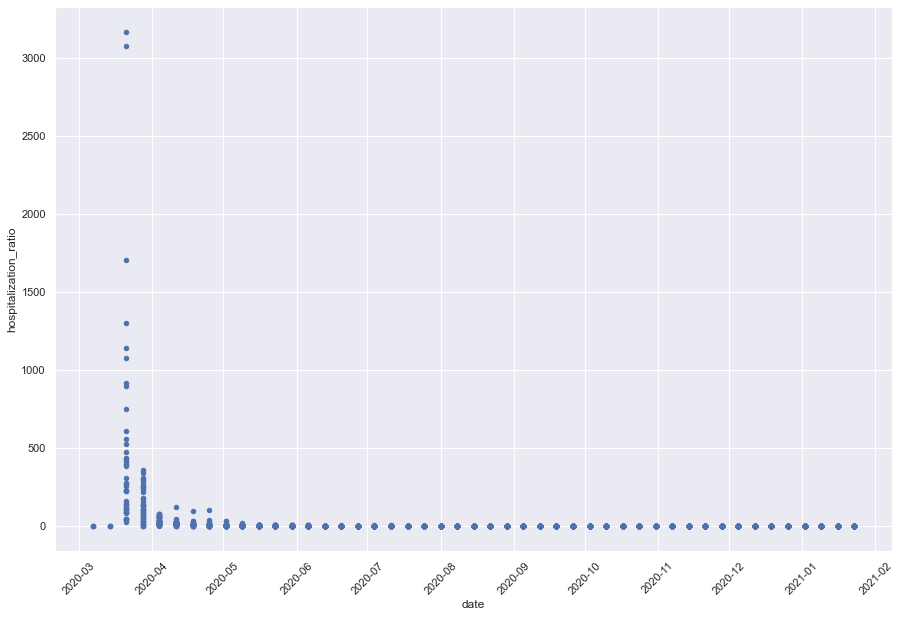

In [508]:
columns = list(combined.columns)
columns.extend(["hospitalization_ratio", "weekly_hospitalization_count", "cumulative_hospitalization_count", "recovery_per_confirmed"])
finalCombined = finalCombined[columns].sort_values("hospitalization_ratio", ascending=False)
finalCombined.plot.scatter(x="date", y="hospitalization_ratio", rot=45)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='date', ylabel='hospitalization_ratio'>

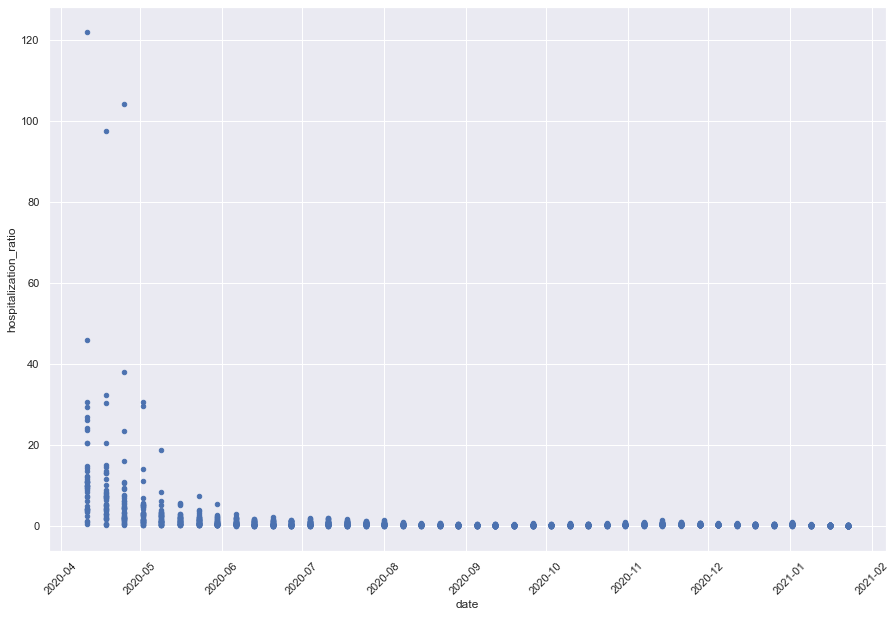

In [509]:
finalCombined[finalCombined["date"] > "04/09/2020"].plot.scatter(x="date", y="hospitalization_ratio", rot=45)

### Yea Humanity just kinda died around March 2020 no cap

### It's quite interesting to see how there was a 14000% hospitalization ratio in March. Maybe no one was ready to collect data when covid happened

In [510]:
finalCombined.head()

,catchment,date,category,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered,hospitalization_ratio,weekly_hospitalization_count,cumulative_hospitalization_count,recovery_per_confirmed
853,Michigan,2020-03-21,race,24.9,24.8,78.0,0.0,0.0,3168.853385,2471.705640,2481.672195,0.0
852,Michigan,2020-03-21,age_category,24.6,24.1,78.0,0.0,0.0,3079.409942,2401.939755,2451.772530,0.0
429,Georgia,2020-03-21,age_category,58.4,44.2,278.0,4.0,0.0,1702.815653,4733.827514,6254.649928,0.0
430,Georgia,2020-03-21,race,40.9,33.8,278.0,4.0,0.0,1302.153146,3619.985746,4380.396953,0.0
854,Michigan,2020-03-21,sex,9.1,8.9,78.0,0.0,0.0,1137.209481,887.023395,906.956505,0.0


## This is for anyone wanting to use this code for some insights!

### Steps:
1. Pick a date range
2. Pick a state or few states
3. Find the weekly rate

In [511]:
print("Here are the available states for study states: %s\n" % finalCombined["catchment"].unique())
print("The date ranges from %s to %s" % (finalCombined["date"].min(), finalCombined["date"].max()))

Here are the available states for study states: ['Michigan' 'Georgia' 'Connecticut' 'Ohio' 'Tennessee' 'Maryland'
 'Colorado' 'California' 'Utah' 'Minnesota' 'Oregon' 'Iowa' 'New Mexico'
 'New York']

The date ranges from 2020-03-07 00:00:00 to 2021-01-23 00:00:00


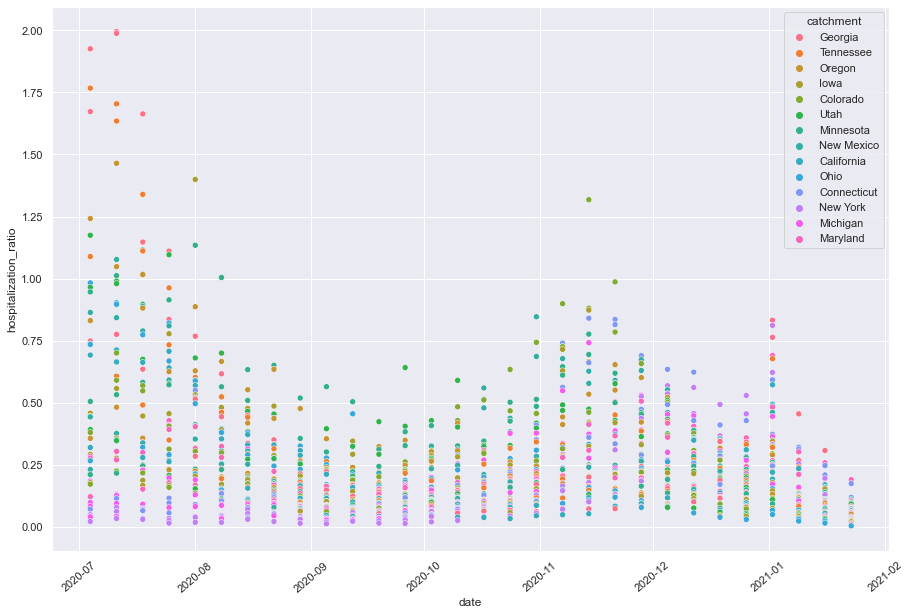

In [512]:
catchments = finalCombined["catchment"].unique()
catchments = "|".join(catchments)

pickARandomState = \
    finalCombined["catchment"].str.contains(catchments) & \
    (finalCombined["date"] >= "2020-07-01") & \
    (finalCombined["date"] <= "2021-01-30")
g = sns.scatterplot(x="date", y="hospitalization_ratio", data=finalCombined[pickARandomState], hue="catchment")
sns.set(rc={'figure.figsize':(15, 10)})
_ = plt.xticks(rotation=40)

## Summary

In [514]:
finalCombined.head()

,catchment,date,category,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered,hospitalization_ratio,weekly_hospitalization_count,cumulative_hospitalization_count,recovery_per_confirmed
853,Michigan,2020-03-21,race,24.9,24.8,78.0,0.0,0.0,3168.853385,2471.705640,2481.672195,0.0
852,Michigan,2020-03-21,age_category,24.6,24.1,78.0,0.0,0.0,3079.409942,2401.939755,2451.772530,0.0
429,Georgia,2020-03-21,age_category,58.4,44.2,278.0,4.0,0.0,1702.815653,4733.827514,6254.649928,0.0
430,Georgia,2020-03-21,race,40.9,33.8,278.0,4.0,0.0,1302.153146,3619.985746,4380.396953,0.0
854,Michigan,2020-03-21,sex,9.1,8.9,78.0,0.0,0.0,1137.209481,887.023395,906.956505,0.0


In [515]:
finalCombined.describe()

,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered,hospitalization_ratio,weekly_hospitalization_count,cumulative_hospitalization_count,recovery_per_confirmed
count,1974.000000,1974.000000,1.896000e+03,1896.000000,1896.000000,1896.000000,1974.000000,1.974000e+03,1896.000000
mean,733.286170,37.115552,1.273042e+06,35841.481013,0.080696,16.306997,3051.583900,5.718373e+04,0.000041
std,772.999229,41.952622,2.062779e+06,57274.758215,1.248673,130.646287,5041.113850,7.818722e+04,0.000753
min,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,195.425000,10.400000,1.688155e+05,3923.750000,0.000000,0.123139,632.248750,1.265053e+04,0.000000
50%,499.600000,23.000000,4.991010e+05,14934.000000,0.000000,0.292419,1663.625279,3.578789e+04,0.000000
75%,1010.500000,47.375000,1.585826e+06,36946.750000,0.000000,0.829085,3553.433257,7.169889e+04,0.000000
max,6052.300000,509.500000,2.016373e+07,282917.000000,28.000000,3168.853385,81767.498006,1.015815e+06,0.017610


In [516]:
finalCombined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 853 to 1838
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   catchment                         1974 non-null   object        
 1   date                              1974 non-null   datetime64[ns]
 2   category                          1974 non-null   object        
 3   cumulative_rate                   1974 non-null   float64       
 4   weekly_rate                       1974 non-null   float64       
 5   Confirmed                         1896 non-null   float64       
 6   Deaths                            1896 non-null   float64       
 7   Recovered                         1896 non-null   float64       
 8   hospitalization_ratio             1896 non-null   float64       
 9   weekly_hospitalization_count      1974 non-null   float64       
 10  cumulative_hospitalization_count  1974 non-nul

In [517]:
## Rearrange the columns to make it look nice
listColumns = list(finalCombined.columns)
index = listColumns.index("date")
columns = listColumns[0:1] + listColumns[index:index+1] + listColumns[1:index] + listColumns[index+1:]


In [519]:
sortedFinal = finalCombined.sort_values(["catchment", "date"])
sortedFinal = sortedFinal[columns]

sortedFinal.head(20)

,catchment,date,category,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered,hospitalization_ratio,weekly_hospitalization_count,cumulative_hospitalization_count,recovery_per_confirmed
0,California,2020-03-07,age_category,0.7,0.7,NaN,NaN,NaN,NaN,275.576546,275.576546,NaN
1,California,2020-03-07,race,0.7,0.7,NaN,NaN,NaN,NaN,275.576546,275.576546,NaN
2,California,2020-03-07,sex,0.4,0.4,NaN,NaN,NaN,NaN,157.472312,157.472312,NaN
3,California,2020-03-14,age_category,4.6,3.9,NaN,NaN,NaN,NaN,1535.355042,1810.931588,NaN
4,California,2020-03-14,race,3.5,2.8,NaN,NaN,NaN,NaN,1102.306184,1377.882730,NaN
5,California,2020-03-14,sex,1.9,1.5,NaN,NaN,NaN,NaN,590.521170,747.993482,NaN
7,California,2020-03-21,race,20.8,17.4,1590.0,24.0,28.0,430.820476,6850.045572,8188.560224,0.017610
6,California,2020-03-21,age_category,15.7,11.0,1590.0,24.0,28.0,272.357772,4330.488580,6180.788246,0.017610
8,California,2020-03-21,sex,6.3,4.4,1590.0,24.0,28.0,108.943109,1732.195432,2480.188914,0.017610
10,California,2020-03-28,race,44.2,23.3,7145.0,127.0,12.0,128.380156,9172.762174,17400.690476,0.001679


In [520]:
sortedFinal.to_csv("./data/merged_data.csv", index=False)

## Have fun :DD